In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.framework import dtypes

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#LOG_DIR = './ops_logs'
n_step = 5
rnn_layers = [{'steps': n_step}]
#dense_layers = [10, 10]
dense_layers = 0
n_iter = 10000
batch_size = 100
display_st = n_iter / 100

In [3]:
def prepare_data_x(data, time_steps, test_size=0.1):
    ntest = int(round(len(data) * (1 - test_size)))
    df_train, df_test = data[:ntest], data[ntest:]
    rnn_train = []
    for i in range(len(df_train) - time_steps):
        data_ = df_train[i: i + time_steps]
        rnn_train.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    #print rnn_train
    rnn_test = []
    for i in range(len(df_test) - time_steps):
        data_ = df_test[i: i + time_steps]
        rnn_test.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_train, dtype="float32"), np.array(rnn_test, dtype="float32")

In [4]:
def prepare_data_y(data, time_steps, test_size=0.1):
    ntest = int(round(len(data) * (1 - test_size)))
    df_train, df_test = data[:ntest], data[ntest:]
    rnn_train = []
    for i in range(len(df_train) - time_steps):
        rnn_train.append(df_train[i + time_steps])
    rnn_test = []
    for i in range(len(df_test) - time_steps):
        rnn_test.append(df_test[i + time_steps])
    return np.array(rnn_train, dtype="float32"), np.array(rnn_test, dtype="float32")

In [5]:
def generate(fct, x, time_steps):
    data = fct(x)
    train_x, test_x = prepare_data_x(data, time_steps)
    train_y, test_y = prepare_data_y(data, time_steps)
    return train_x, test_x, train_y, test_y

In [6]:
def super_sin(a, b, c):
    def _sin(x):
        return (np.sin(a*x + b) + c)
    return _sin

In [7]:
X_train, X_test, y_train, y_test = generate(super_sin(2, 3, 4), np.linspace(0, 100, 10000), n_step)
print len(X_test), len(y_test), len(X_train), len(y_train)
y_train.dtype

995 995 8995 8995


dtype('float32')

In [8]:
def lstm_model(time_steps, rnn_layers, dense_layers=None):
    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                               state_is_tuple=True),
                                                  layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                                state_is_tuple=True)
                    for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        print input_layers
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return tf.contrib.layers.fully_connected(input_layers, layers)
        else:
            return input_layers

    def _lstm_model(X, y, mode, params):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = tf.unstack(X, time_steps, 1, name='unstack')
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        predictions, mse = learn.models.linear_regression(output, y)
        train_op = tf.contrib.layers.optimize_loss(loss=mse,
                                                   global_step=tf.contrib.framework.get_global_step(),
                                                   learning_rate=params['learning_rate'],
                                                   optimizer=params['optimizer'])

        return predictions, mse, train_op

    return _lstm_model

In [9]:
regressor = learn.SKCompat(learn.Estimator(model_fn=lstm_model(n_step, rnn_layers, dense_layers), 
                            params={'n_classes':0,
                                   'verbose':1,  
                                   'steps':n_iter, 
                                   'optimizer':'Adagrad',
                                   'learning_rate':0.03, 
                                   'batch_size':batch_size
                                   }))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'save_summary_steps': 100, '_num_ps_replicas': 0, '_task_type': None, '_environment': 'local', '_is_chief': True, 'save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f28ef2d84d0>, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_id': 0, 'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', 'save_checkpoints_steps': None, '_master': '', 'keep_checkpoint_max': 5}


In [10]:
regressor.fit(X_train, y_train, steps=5000)

Tensor("RNN/MultiRNNCell_4/Cell0/BasicLSTMCell/mul_2:0", shape=(?, 5), dtype=float32)
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:loss = 10.954, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpzM9cy6/model.ckpt.
INFO:tensorflow:loss = 0.304843, step = 101
INFO:tensorflow:global_step/sec: 326.542
INFO:tensorflow:loss = 0.0417061, step = 201
INFO:tensorflow:global_step/sec: 505.28
INFO:tensorflow:loss = 0.0150324, step = 301
INFO:tensorflow:global_step/sec: 516.19
INFO:tensorflow:loss = 0.00719619, step = 401
INFO:tensorflow:global_step/sec: 537.762
INFO:tensorflow:loss = 0.00664832, step = 501
INFO:tensorflow:global_step/sec: 535.441
INFO:tensorflow:loss = 0.00644331, step = 601
INFO:tensorflow:global_step/sec: 490.47
INFO:tensorflow:loss = 0.00611748, step = 701
INFO:tensorflow:global_step/sec: 469.435
INFO:tensorflow:loss = 0.00517083, step = 801
INFO:t

SKCompat()

In [11]:
predicted = regressor.predict(X_test)
mse = mean_squared_error(y_test, predicted)
print ("Error: %f" % mse)

Tensor("RNN/MultiRNNCell_4/Cell0/BasicLSTMCell/mul_2:0", shape=(?, 5), dtype=float32)
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
INFO:tensorflow:Loading model from checkpoint: /tmp/tmpzM9cy6/model.ckpt-5000-?????-of-00001.
Error: 0.002834


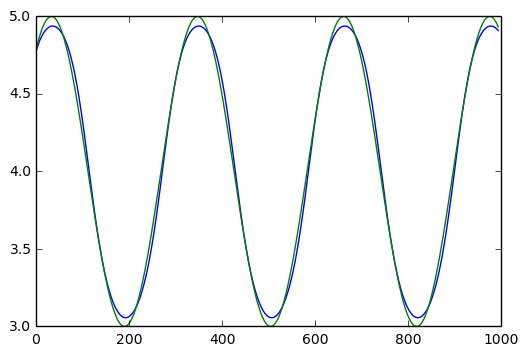

In [12]:
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(y_test, label='test')